In [9]:
from tensorflow.keras.models import load_model
from skimage import filters
import matplotlib.pyplot as plt 
from random import randint
from skimage import transform
import tensorflow as tf
import pandas as pd
import nibabel as nib
import scipy
import os 
import numpy as np
import random
import pickle
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error
import seaborn as sns


/Users/elena/miniconda3/envs/aicuram/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [10]:
### rescale functions
def y_scaler(x, max_val=1):
    """Scale between 0 and 1
    x: data to be scaled,
    max_val: maximum value of dice, default=1."""
    min_val = np.nanmean(x, axis=0)
    x_std = (x - min_val) / (max_val - min_val)
    return x_std, min_val, max_val

def y_inv_scaler(x, min_val, max_val):
    return x * (max_val - min_val) + min_val
def rescale(data, max=255):
    '''
    rescale array to [0 max]
    '''
    
    data = data-np.min(np.ravel(data))
    data = max* (data/np.max(np.ravel(data)))
    return data

## Evaluation

In [86]:
# load the data to test the evaluation pipeline
with open('1x_test.pkl', 'rb') as f:
    x = pickle.load(f)

with open('1entropy_unc_test.pkl', 'rb') as f:
    entropy_map = pickle.load(f)

with open('1prediction_test.pkl', 'rb') as f:
    prediction = pickle.load(f)

dice_val = np.loadtxt('1dice_test.txt', dtype=float)
x = np.squeeze(x, axis=1)
prediction = prediction[:,:,:,:,1]
entropy_map = entropy_map[:,:,:,:,1]
flair = x[:,:,:,:,1]
entropy_map = rescale(entropy_map, max=1)

flair_n = (flair - flair.mean(axis=0)) / flair.std(axis=0)


In [223]:
x_input = np.stack((prediction, entropy_map), axis=4)

In [221]:
model = load_model('1best_model_PE.hdf5')

In [224]:
pred = model.predict(x_input)

In [225]:
pred = pred.flatten()

In [226]:
np.sqrt(np.square(np.subtract(dice_val, pred)).mean())

mean_absolute_error(dice_val, pred)

0.04796784260944911

In [90]:
pred[10:20]

array([0.8378905 , 0.924525  , 0.8121928 , 0.8016598 , 0.8434284 ,
       0.8820362 , 0.8918079 , 0.8336859 , 0.8186295 , 0.89616406],
      dtype=float32)

In [47]:
dice_val[10:20]

array([0.91492456, 0.81621265, 0.89977753, 0.9161458 , 0.93707788,
       0.79076397, 0.92945701, 0.80630529, 0.74516278, 0.86934215])

Correlation coefficient

In [254]:
import scipy.stats
scipy.stats.pearsonr(dice_val, pred)

(0.710877572819552, 0.00030371183791010726)

Perform Dice filtering

In [256]:
dice_filtered = dice_val[pred > 0.7]
dice_filtered.mean()

0.8191111286190476

Scatterplot

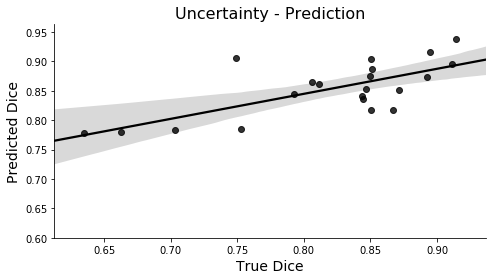

In [234]:
length = 1
marks=np.arange(0.6,1.0,0.05)
plt.figure(figsize=(7,4))
sns.regplot(dice_val, pred, 'o', color='black')
plt.xlabel('True Dice', fontsize=14)
plt.ylabel('Predicted Dice', fontsize=14)
plt.yticks(marks)
sns.despine(left=False, bottom=False, top=True, right=True)
plt.title('Uncertainty - Prediction', fontsize=16)

plt.tight_layout()
plt.savefig('reg_scatter_PE.pdf')

# Image + Prediction

In [99]:
x_input.shape

(21, 128, 128, 128, 2)

In [235]:
model = load_model('1best_model_IP.hdf5')
x_input = np.stack((prediction, flair_n), axis=4)
pred2 = model.predict(x_input)
pred2 = pred2.flatten()

Correlation coefficient

In [251]:
import scipy.stats
scipy.stats.pearsonr(dice_val, pred2)

(0.5974782581160906, 0.004234783776477339)

Scatterplot

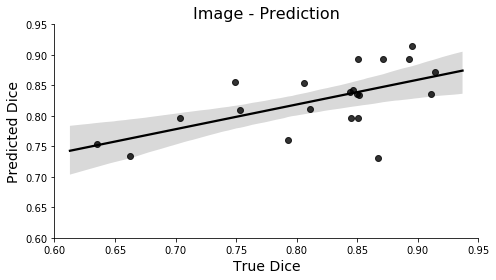

In [250]:
length = 1
marks=np.arange(0.6,1.0,0.05)
plt.figure(figsize=(7,4))
sns.regplot(dice_val, pred2, 'o', color='black')

plt.xlabel('True Dice', fontsize=14)
plt.ylabel('Predicted Dice', fontsize=14)
plt.yticks(marks)
plt.xticks(marks)
sns.despine(left=False, bottom=False, top=True, right=True)
plt.title('Image - Prediction', fontsize=16)

plt.tight_layout()
plt.savefig('reg_scatter_IP.pdf')

In [248]:
prediction = pred2

Perform Dice filtering

In [252]:
dice_filtered = dice_val[prediction > 0.8]
dice_filtered.mean()

0.8461305030714286

In [111]:
dice_val.mean()

0.8191111286190476

# EM

In [244]:
pred3 = np.loadtxt("1predictions_em.txt", dtype=float)
pred3 = pred3.flatten()

In [245]:

mean_absolute_error(dice_val, pred3)


0.10213809633333333

Correlation coefficient

In [203]:
import scipy.stats
scipy.stats.pearsonr(dice_val, pred3)

(0.7329511386604605, 0.00015720099987267549)

Scatterplot

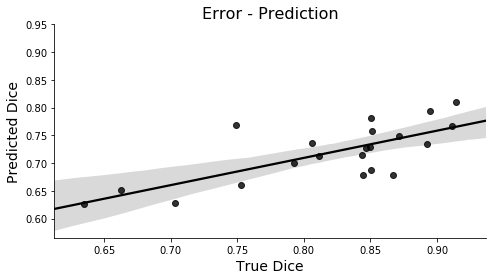

In [247]:
length = 1
plt.figure(figsize=(7,4))
sns.regplot(dice_val, pred3, 'o', color='black')

plt.xlabel('True Dice', fontsize=14)
plt.ylabel('Predicted Dice', fontsize=14)
plt.yticks(marks)
sns.despine(left=False, bottom=False, top=True, right=True)
plt.title('Error - Prediction', fontsize=16)
plt.tight_layout()

plt.savefig('reg_scatter_EM.pdf')

## Training history

## Prediction - Uncertainty training history

In [162]:
fold1 = pd.read_csv("training_hist/1training_PE.csv", nrows=60)
fold2 = pd.read_csv("training_hist/2training_PE.csv", nrows=60)
fold3 = pd.read_csv("training_hist/3training_PE.csv", nrows=60)
fold4 = pd.read_csv("training_hist/4training_PE.csv", nrows=60)
fold5 = pd.read_csv("training_hist/5training_PE.csv", nrows=60)
df_loss = pd.concat([fold1.loss, fold2.loss, fold3.loss, fold4.loss, fold5.loss], axis=1)
df_loss = df_loss.median(axis=1)
df_val_loss = pd.concat([fold1.val_loss, fold2.val_loss, fold3.val_loss, fold4.val_loss, fold5.val_loss], axis=1)
df_val_loss = df_val_loss.median(axis=1)
df_final = pd.concat([df_loss, df_val_loss], axis=1)

In [165]:
length = 1
marks=np.arange(0.0,0.1,0.02)

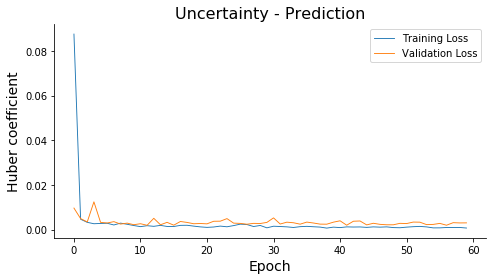

In [169]:

df_final.plot(figsize=(7,4), lw=0.9)
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Huber coefficient', fontsize=14)
plt.yticks(marks)
sns.despine(left=False, bottom=False, top=True, right=True)
plt.title('Uncertainty - Prediction', fontsize=16)

plt.tight_layout()
plt.savefig('reg_training_PE.pdf')

plt.show()

## Image - Prediction training history

In [170]:
fold1 = pd.read_csv("training_hist/1training_IP.csv", nrows=60)
fold2 = pd.read_csv("training_hist/2training_IP.csv", nrows=60)
fold3 = pd.read_csv("training_hist/3training_IP.csv", nrows=60)
fold4 = pd.read_csv("training_hist/4training_IP.csv", nrows=60)
fold5 = pd.read_csv("training_hist/5training_IP.csv", nrows=60)


In [171]:
df_loss = pd.concat([fold1.loss, fold2.loss, fold3.loss, fold4.loss, fold5.loss], axis=1)
df_loss = df_loss.mean(axis=1)
df_val_loss = pd.concat([fold1.val_loss, fold2.val_loss, fold3.val_loss, fold4.val_loss, fold5.val_loss], axis=1)
df_val_loss = df_val_loss.mean(axis=1)

In [172]:
df_final = pd.concat([df_loss, df_val_loss], axis=1)

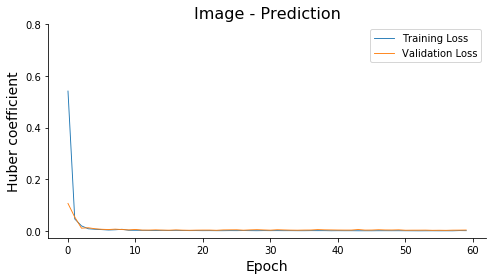

In [175]:
length = 1
marks=np.arange(0.0,1.0,0.2)
df_final.plot(figsize=(7,4), lw=0.9)
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Huber coefficient', fontsize=14)
plt.yticks(marks)
sns.despine(left=False, bottom=False, top=True, right=True)
plt.title('Image - Prediction', fontsize=16)

plt.tight_layout()
plt.savefig('reg_training_IP.pdf')

plt.show()

# EM training history

In [194]:
fold1 = pd.read_csv("training_hist_4/1training_EM.csv", nrows=60)
fold2 = pd.read_csv("training_hist_4/2training_EM.csv", nrows=60)
fold3 = pd.read_csv("training_hist_4/3training_EM.csv", nrows=60)
fold4 = pd.read_csv("training_hist_4/4training_EM.csv", nrows=60)
fold5 = pd.read_csv("training_hist_4/5training_EM.csv", nrows=60)
df_loss = pd.concat([fold1.loss, fold2.loss, fold3.loss, fold4.loss, fold5.loss], axis=1)
df_loss = df_loss.median(axis=1)
df_val_loss = pd.concat([fold1.val_loss, fold2.val_loss, fold3.val_loss, fold4.val_loss, fold5.val_loss], axis=1)
df_val_loss = df_val_loss.median(axis=1)
df_final = pd.concat([df_loss, df_val_loss], axis=1)

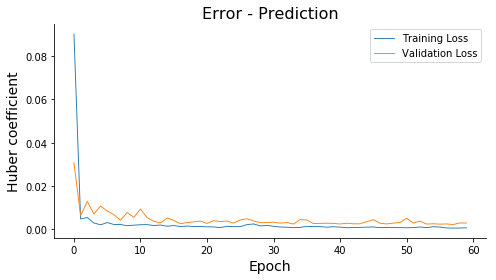

In [200]:
length = 1
marks=np.arange(0.0,0.1,0.02)

df_final = pd.concat([df_loss, df_val_loss], axis=1)
df_final.plot(figsize=(7,4), lw=0.9)
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Huber coefficient', fontsize=14)
sns.despine(left=False, bottom=False, top=True, right=True)
plt.title('Error - Prediction', fontsize=16)

plt.tight_layout()
plt.savefig('reg_training_EM.pdf')

plt.show()

Perform Dice filtering

In [253]:
dice_filtered = dice_val[pred3 > 0.8]
dice_filtered.mean()

0.914446175

In [8]:
df['val_loss'].min()

0.0016193461415241472

# Evaluation results, folds 1-5

## Prediction-uncertainty map pair

In [48]:
MAE1 = 0.047973144063495454
corr1 = 0.7108146882714351
RMSE1 = 0.06387526681375012

MAE2 = 0.04033923266274588
corr2 = 0.7720850330552527
RMSE2 = 0.053359896251671333

MAE3 = 0.0378244038536435
corr3 = 0.7713863361142241
RMSE3 = 0.04763849770047864

MAE4 = 0.044984109556107287
corr4 = 0.6265191703453622
RMSE4 = 0.06021253883364166

MAE5 = 0.07183215300242107
corr5 = 0.6812766812556742
RMSE5 = 0.09136211893869095

### Mean MAE across 5 folds

In [50]:
np.mean([MAE1,MAE2,MAE3,MAE4,MAE5])

0.04859060862768264

### Mean Pearson correlation coef

In [52]:
np.mean([corr1,corr2,corr3,corr4,corr5])

0.7124163818083897

## Image-Prediction pair

In [53]:
MAE1 = 0.0478995219366891
corr1 = 0.5975494061888778
RMSE1 = 0.061796678395252054

MAE2 = 0.05082001462663924
corr2 = 0.6382564882697399
RMSE2 = 0.06296075529198564

MAE3 = 0.0538627070517767
corr3 = 0.5377275543944673
RMSE3 = 0.0709890029899331

MAE4 = 0.05355394519170127
corr4 = 0.45715001629522256
RMSE4 = 0.06861878430438444

MAE5 = 0.05712211238770258
corr5 = 0.6630077053351241
RMSE5 = 0.07376640717749333

In [54]:
# MAE across 5 folds
np.mean([MAE1,MAE2,MAE3,MAE4,MAE5])

0.052651660238901776

In [56]:
# CORR
np.mean([corr1,corr2,corr3,corr4,corr5])

0.5787382340966862

## Error map + Prediction

In [187]:
MAE1 = 0.10213583190554665
corr1 = 0.7329076617735331

MAE2 = 0.04151175984882173
corr2 = 0.7442825211990773

MAE3 = 0.03558920226324173
corr3 = 0.7638584726870391

MAE4 = 0.056916024802979984
corr4 = 0.42591081550289556

MAE5 = 0.06038189314433508
corr5 = 0.7156173387407893

# MAE across 5 folds
np.mean([MAE1,MAE2,MAE3,MAE4,MAE5])

0.05930694239298503

In [188]:
# CORR across 5 folds
np.mean([corr1,corr2,corr3,corr4,corr5])


0.6765153619806668